# Partitioned Convolution

*This notebook uses [[Wefers, 2015]](README.md) as reference.*

Partitioned covolution is a technique that breaks up the input sequence and/or the filter impulse response into *blocks* to increase the efficency of convolution computations. 

## Input Partitioning

Input partitioning involves splitting up an input sequence of potentially indefinte length into blocks of length $B$. The following function below can be used to partition an input sequence of arbitrary size.

In [1]:
import numpy as np

def partition_input(input, B):
    """Partition input sequence of arbitrary size into blocks of length B. 
    The last block is zero padded if the input is not equally divisible by B.
    """
    block_cnt = int(np.ceil(len(input) / B))
    zero_pad_cnt = block_cnt * B - len(input)
    zero_padded_input = np.pad(input, (0, zero_pad_cnt))
    partitioned_input = np.reshape(zero_padded_input, (block_cnt, B))
    return partitioned_input

## Filter Partitioning

Filter partitioning involves splitting up a FIR filters impulse response into sections. There are several methods that can be used to partition a filters impulse response. The method that is selected defines the different classes of convolution algorithms that can be used.

Partitioning a filter with an impulse response of length-$N$ involves splitting up the impulse response into $P$ sub filters of length $N_0, ..., N_{P-1}$ such that: 

$$\sum_{i = 0}^{P-1} N_i = N$$

Or in cases where the subfilters are zero-padded, the following realtionship holds true:

$$\sum_{i = 0}^{P-1} N_i \ge N$$

Each sub filter impulse response $h_i(n)$ relates to a connected interval $n_i^{first} \le n \le n_i^{last}$ in the original filter impulse response $h(n)$, and all sub filters are adjoining, such that $n_{i+1}^{first} = n_i^{last} + 1$.

The *sub filter length* $N_i$ is defined as:
$$N_i = n_i^{last} - n_i^{first} + 1$$

The position of the sub filter within the original impulse response is:
$$n_i^{first} = \sum_{j<i} N_j$$

The original filter $h(n)$ can be described by the following composition of sub filters:

$$h(n) = \sum_{i = 0}^{P-1} h_i(n - n_i^{first})$$

Each consecutive sub filter impulse respose must be the same size or larger than the previous sub filter impulse response such that (TODO: discuss why this is...):

$$N_0 \le N_1 \le ... \le N_{P-1}$$

 If there is only 1 partition, the filter is called *unpartitioned*. If all the sub filters in a partition are of equal size, the filter is called a *uniform partition*, otherwise it is called a *non-uniform partition*.

## Filter Structure

Inserting the partitioned filter into the linear convolution equation gives us:

$$\begin{aligned}
y(n) \quad &= \quad x(n) * h(n) \\
&= \quad x(n) * \left[ \sum_{i=0}^{P-1} h_i(n - n_i^{first}) \right] 
\end{aligned}$$

And then converting the delays to time-shifted unit impulses gives us the following two equations: 

$$\begin{aligned}
y(n) \quad &= \quad \sum_{i=0}^{P-1} \left[ \left[ x(n) * \delta(n - n_i^{first}) \right] * h_i(n) \right] \\
&= \quad \sum_{i=0}^{P-1} \left[ \left[ x(n) * h_i(n) \right] * \delta(n - n_i^{first}) \right]
\end{aligned}$$

Both of these equations are equivalent since convolution is commutative. This illustrates that the delays can be moved around when performing the convolution.

## Classification of Partitioned Convolution Algorithms

The image below illustrates different classes of convolution algorithms based on the partitioning of the input sequence and the filter. Only *uniformly partitioned* input sequences are considered for real-time processing, although the other categories can be useful for offline processing.

![](images/partitioned_convolution_classification.png 'Classes of Convolution Algorithms')
<br>*Classes of Convolution Algorithms: [[Wefers, 2015]](README.md)*

## Running Convolutions

Linear convolution of a partitioned input sequence with an unpartitioned filter can be performed using the *Overlap-Add* method or the *Overlap-save* method described below.



### Overlap-Add

The overlap-add partitioned convolution method involves the following operations:

* Zero-pad a block of $B$ input samples to a length of $K$ and take the $K$-point FFT.
* Zero-pad the filters $N$-point impulse response to a length of $K$ and take the $K$-point FFT.
* Perform an element-wise complex multiplication between the input and the filters DFT coefficients.
* Transform the results of the FFT back to the time-domain using a $K$-point IFFT and buffer the partial convolution result of $B+N-1$ samples.
* Sum up $B$ samples from the overlapping partial convolution results to get the filtered output.

In order to avoid time-aliasing, the transform size $K$ must be chosen such that the following holds true:

$$K \ge B + N - 1$$

Illustrated below is a block diagram of the overlap-add method, and below that is an implementation in code.

![](images/overlap_add_method.png 'Overlap-Add Running Convolution')
<br>*Overlap-Add Running Convolution: [[Wefers, 2015]](README.md)*

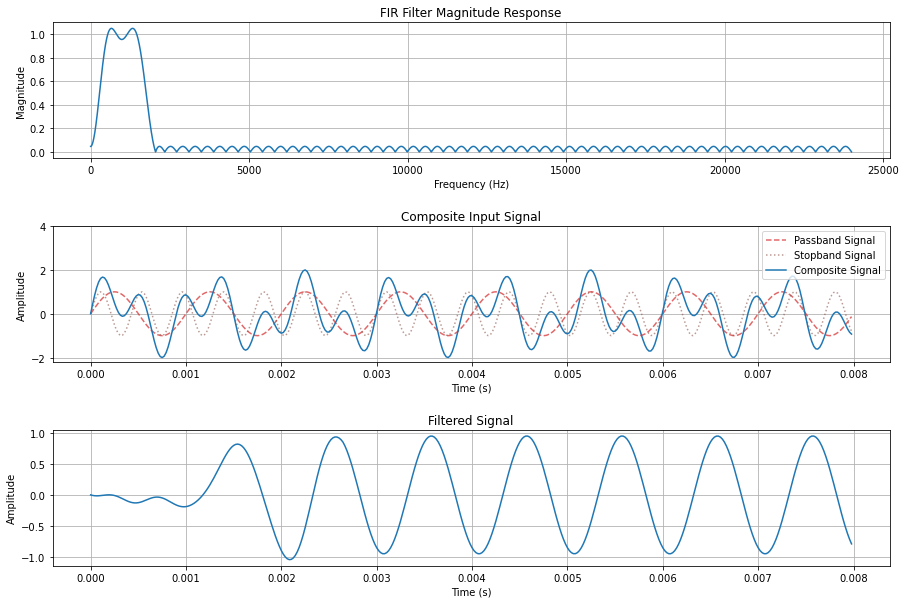

In [2]:
# Overlap-Add Demo

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import remez, freqz
from scipy.fft import fft, ifft

# Sample rate and period
Fs = 48e3
Ts = 1/Fs

# Number of input samples per block
B = 128

# Number of FFT bins
K = 256

# Number of filter taps
N = 128

assert N+B-1 <= K, 'Number of FFT bins K must increase, otherwise there will be time aliasing'

# Number of blocks to process
num_blocks = 3
n = np.arange(0, num_blocks*B)

# Input signal
# Signal in passband
A_pb = 1
f_pb = 1000
x_pb = A_pb * np.sin(2*np.pi*f_pb*n*Ts)
# Signal in stopband
A_sb = 1
f_sb = 2337
x_sb = A_sb * np.sin(2*np.pi*f_sb*n*Ts)
x = x_pb + x_sb

# Partition the input signal into blocks and zero pad
x_part = partition_input(x, B)
x_part_zp = np.pad(x_part, ((0, 0), (0, K-B)))

# Create FIR filter using the Remez exchange algorithm
band = [500, 1500]  # Desired pass band, Hz
trans_width = 500   # Width of transition from pass band to stop band, Hz
edges = [0, band[0] - trans_width, band[0], band[1],
         band[1] + trans_width, Fs/2]
h = remez(N, edges, [0, 1, 0], fs=Fs)

# Calculate the frequency response of the designed filter with 1 Hz resolution
f_freqz, h_freqz = freqz(h, [1], worN=int(Fs), fs=Fs)

# Zero pad filter coefficients and calculte the FFT
# (Used for frequency domain filtering)
h_zp = np.pad(h, (0, K-N))
h_fft = fft(h_zp)

# Initialize overlap and add results array and output array
overlap_add_result = np.zeros(B+N-1)
y_arr = np.zeros((num_blocks, B))

# Filter data using the overlap-add method
for block in range(num_blocks):
    x_fft = fft(x_part_zp[block, :])
    filtered_fft = h_fft * x_fft
    ifft_result = np.real(ifft(filtered_fft))
    overlap_add_result += ifft_result[:B+N-1]
    y_arr[block, :] = overlap_add_result[:B]
    overlap_add_result = np.pad(overlap_add_result, (0, B))[B:]

# Convert output to a 1D array
y = y_arr.flatten()

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(15, 10))

# Plot filter frequency response
ax[0].grid()
ax[0].plot(f_freqz, np.abs(h_freqz))
ax[0].set_xlabel('Frequency (Hz)')
ax[0].set_ylabel('Magnitude')
ax[0].set_title('FIR Filter Magnitude Response')

# Plot composite input signal
ax[1].grid()
ax[1].plot(n*Ts, x_pb, '--', c='C3', alpha=0.7, label='Passband Signal')
ax[1].plot(n*Ts, x_sb, ':', c='C5', alpha=0.6, label='Stopband Signal')
ax[1].plot(n*Ts, x, c='C0', label='Composite Signal')
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('Amplitude')
ax[1].set_title('Composite Input Signal')
ax[1].set_ylim(top=2*(A_pb + A_sb))
ax[1].legend(loc='upper right')

# Plot filtered output signal
ax[2].grid()
ax[2].plot(n*Ts, y)
ax[2].set_xlabel('Time (s)')
ax[2].set_ylabel('Amplitude')
ax[2].set_title('Filtered Signal')

plt.subplots_adjust(hspace=0.5)
pass

### Overlap-Save

The overlap-save partitioned convolution method is very similar to the overlap-add method, but with the following differences:

* The input FFT is computed from a $K$-point sliding window of input data, where the data is shifted from the right to the left in the window.
* The $K-B$ leftmost samples in the result of the IFFT are time-aliased, so they are discarded. The rightmost $B$ samples are the ones that get saved into the output blocks. 

Because of the periodic nature of the transform, the overlap-save algorithm can be modified such that the input and filter buffers are circularly shifted, altering the position that the data is written to the input and filter buffers and read from the output buffer. By circular shifting, it is possible to move the valid output block from the rightmost position of the output buffer to the leftmost position, which can be advantageous when computing partial inverse transforms. 

In order to avoid time-aliasing, the transform size $K$ must be chosen such that the following holds true:

$$K \ge B + N - 1$$

Illustrated below is a block diagram of the overlap-save method, and below that is an implementation in code.

![](images/overlap_save_method.png 'Overlap-Save Running Convolution')
<br>*Overlap-Save Running Convolution: [[Wefers, 2015]](README.md)*

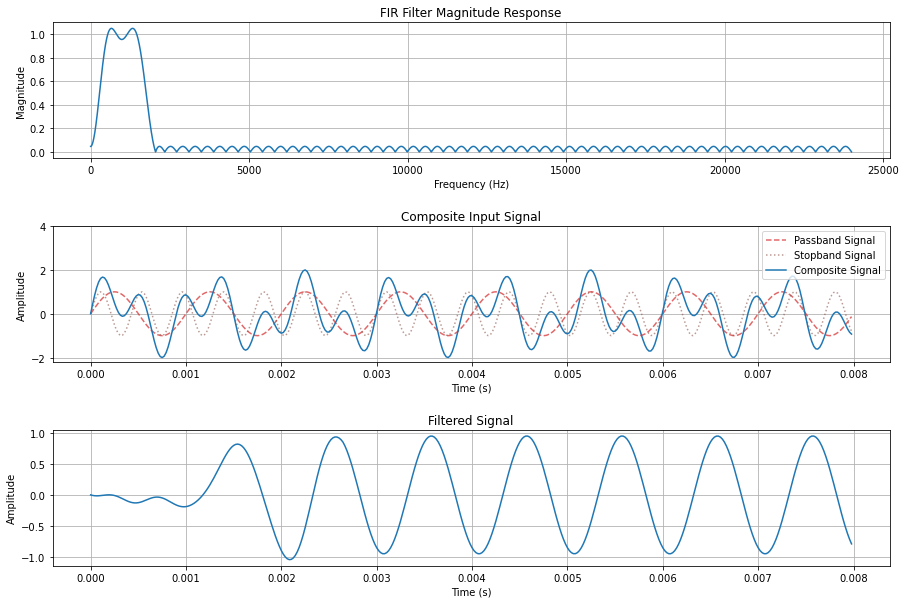

In [3]:
# Overlap-Save Demo

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import remez, freqz
from scipy.fft import fft, ifft

# Sample rate and period
Fs = 48e3
Ts = 1/Fs

# Number of input samples per block
B = 128

# Number of FFT bins
K = 256

# Number of filter taps
N = 128

assert N+B-1 <= K, 'Number of FFT bins K must increase, otherwise there will be time aliasing'

# Number of blocks to process
num_blocks = 3
n = np.arange(0, num_blocks*B)

# Input signal
# Signal in passband
A_pb = 1
f_pb = 1000
x_pb = A_pb * np.sin(2*np.pi*f_pb*n*Ts)
# Signal in stopband
A_sb = 1
f_sb = 2337
x_sb = A_sb * np.sin(2*np.pi*f_sb*n*Ts)
x = x_pb + x_sb

# Partition the input signal into blocks and zero pad
x_part = partition_input(x, B)

# Create FIR filter using the Remez exchange algorithm
band = [500, 1500]  # Desired pass band, Hz
trans_width = 500   # Width of transition from pass band to stop band, Hz
edges = [0, band[0] - trans_width, band[0], band[1],
         band[1] + trans_width, Fs/2]
h = remez(N, edges, [0, 1, 0], fs=Fs)

# Calculate the frequency response of the designed filter with 1 Hz resolution
f_freqz, h_freqz = freqz(h, [1], worN=int(Fs), fs=Fs)

# Zero pad filter coefficients and calculte the FFT
# (Used for frequency domain filtering)
h_zp = np.pad(h, (0, K-N))
h_fft = fft(h_zp)

# Initialize input sliding window and output array
input_sliding_window = np.zeros(K)
y_arr = np.zeros((num_blocks, B))

# Filter data using the overlap-save method
for block in range(num_blocks):
    input_sliding_window = np.pad(input_sliding_window,(0,B))[B:]
    input_sliding_window[-B:] = x_part[block, :]
    x_fft = fft(input_sliding_window)
    filtered_fft = h_fft * x_fft
    ifft_result = np.real(ifft(filtered_fft))
    y_arr[block, :] = ifft_result[-B:]

# Convert output to a 1D array
y = y_arr.flatten()

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(15, 10))

# Plot filter frequency response
ax[0].grid()
ax[0].plot(f_freqz, np.abs(h_freqz))
ax[0].set_xlabel('Frequency (Hz)')
ax[0].set_ylabel('Magnitude')
ax[0].set_title('FIR Filter Magnitude Response')

# Plot composite input signal
ax[1].grid()
ax[1].plot(n*Ts, x_pb, '--', c='C3', alpha=0.7, label='Passband Signal')
ax[1].plot(n*Ts, x_sb, ':', c='C5', alpha=0.6, label='Stopband Signal')
ax[1].plot(n*Ts, x, c='C0', label='Composite Signal')
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('Amplitude')
ax[1].set_title('Composite Input Signal')
ax[1].set_ylim(top=2*(A_pb + A_sb))
ax[1].legend(loc='upper right')

# Plot filtered output signal
ax[2].grid()
ax[2].plot(n*Ts, y)
ax[2].set_xlabel('Time (s)')
ax[2].set_ylabel('Amplitude')
ax[2].set_title('Filtered Signal')

plt.subplots_adjust(hspace=0.5)
pass